# Récupération des données

Import

In [182]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

Ouverture du fichier csv de data 

In [183]:
df = pd.read_csv("../data/marketing_campaign.csv", sep=";")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


Je vois qu'on a des colonnes qu'on pourra encoder

# Cleaning des données
### Supression des colonnes inutiles

In [184]:
print("Nombre de doublons :", df.duplicated().sum())
print("Valeurs nulles par colonne :\n", df.isnull().sum())

Nombre de doublons : 0
Valeurs nulles par colonne :
 ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


Aucune valeur null ni doublon

Suppressions des colonnes comportant une seule valeur, ou inutile

In [185]:
# Identifier et supprimer les colonnes avec une seule valeur unique
delete_columns = []
for col in df.columns:
    if df[col].nunique() == 1:
        delete_columns.append(col)
        print(f"Colonne {col}")

df = df.drop(columns=delete_columns)
print(f"{len(delete_columns)} colonne(s) supprimée(s)")
print(f"Forme du dataframe: {df.shape}")

Colonne Z_CostContact
Colonne Z_Revenue
2 colonne(s) supprimée(s)
Forme du dataframe: (2240, 27)


In [186]:
useless_columns = ["ID", "Dt_Customer", "Year_Birth"]
df = df.drop(columns=useless_columns)

# Visualisation
### Matrice de corrélation

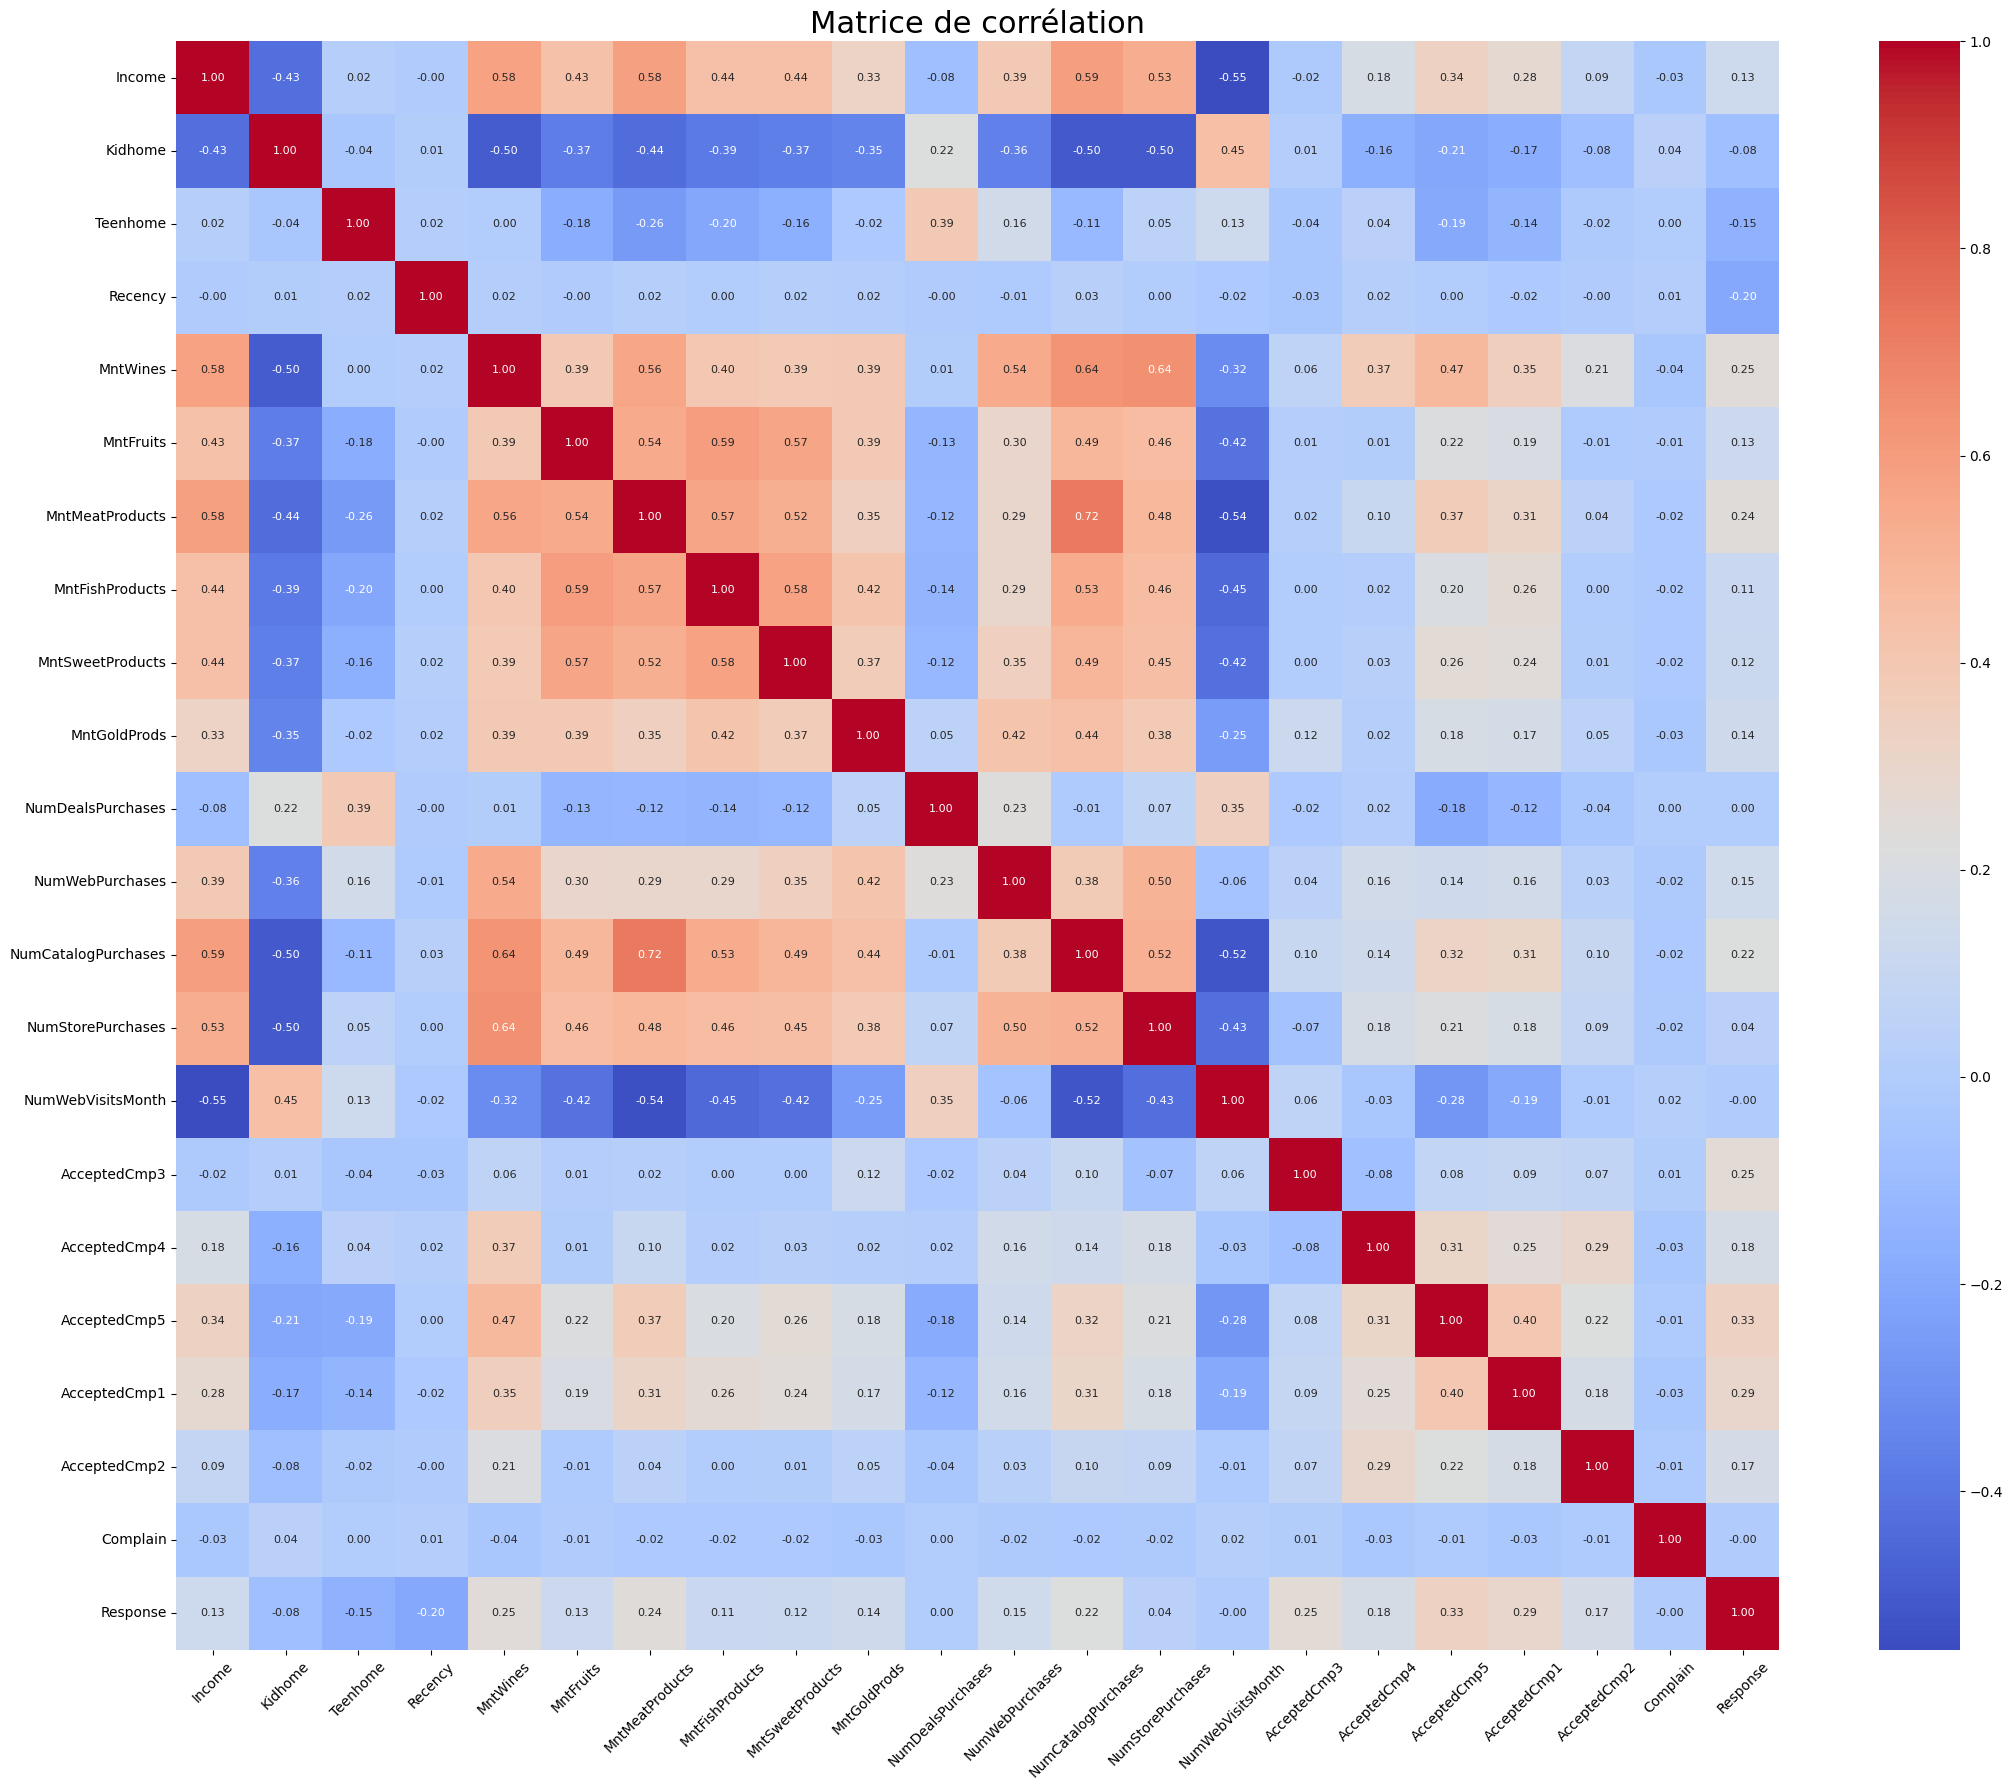

In [187]:
plt.figure(figsize=(22, 18))  
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"size": 8}  
)
plt.title("Matrice de corrélation", fontsize=22)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()  
plt.show()

On voie des colonne qui on de forte corrélation entre elle 

### Verification outliers

Outliers les plus important à normaliser sont les accepted campaigns car naturellement elles sont corrlé avec la response

In [188]:
colonnes_numeriques = df.select_dtypes(include=['float64', 'int64']).columns

for col in colonnes_numeriques:
    moyenne = df[col].mean()
    ecart_type = df[col].std()
    outliers = df[(df[col] < moyenne - 3 * ecart_type) | (df[col] > moyenne + 3 * ecart_type)]
    print(f"{col}: {len(outliers)} outliers")

Income: 8 outliers
Kidhome: 0 outliers
Teenhome: 0 outliers
Recency: 0 outliers
MntWines: 16 outliers
MntFruits: 64 outliers
MntMeatProducts: 37 outliers
MntFishProducts: 58 outliers
MntSweetProducts: 62 outliers
MntGoldProds: 44 outliers
NumDealsPurchases: 32 outliers
NumWebPurchases: 4 outliers
NumCatalogPurchases: 4 outliers
NumStorePurchases: 0 outliers
NumWebVisitsMonth: 9 outliers
AcceptedCmp3: 163 outliers
AcceptedCmp4: 167 outliers
AcceptedCmp5: 163 outliers
AcceptedCmp1: 144 outliers
AcceptedCmp2: 30 outliers
Complain: 21 outliers
Response: 0 outliers


### Loie normale

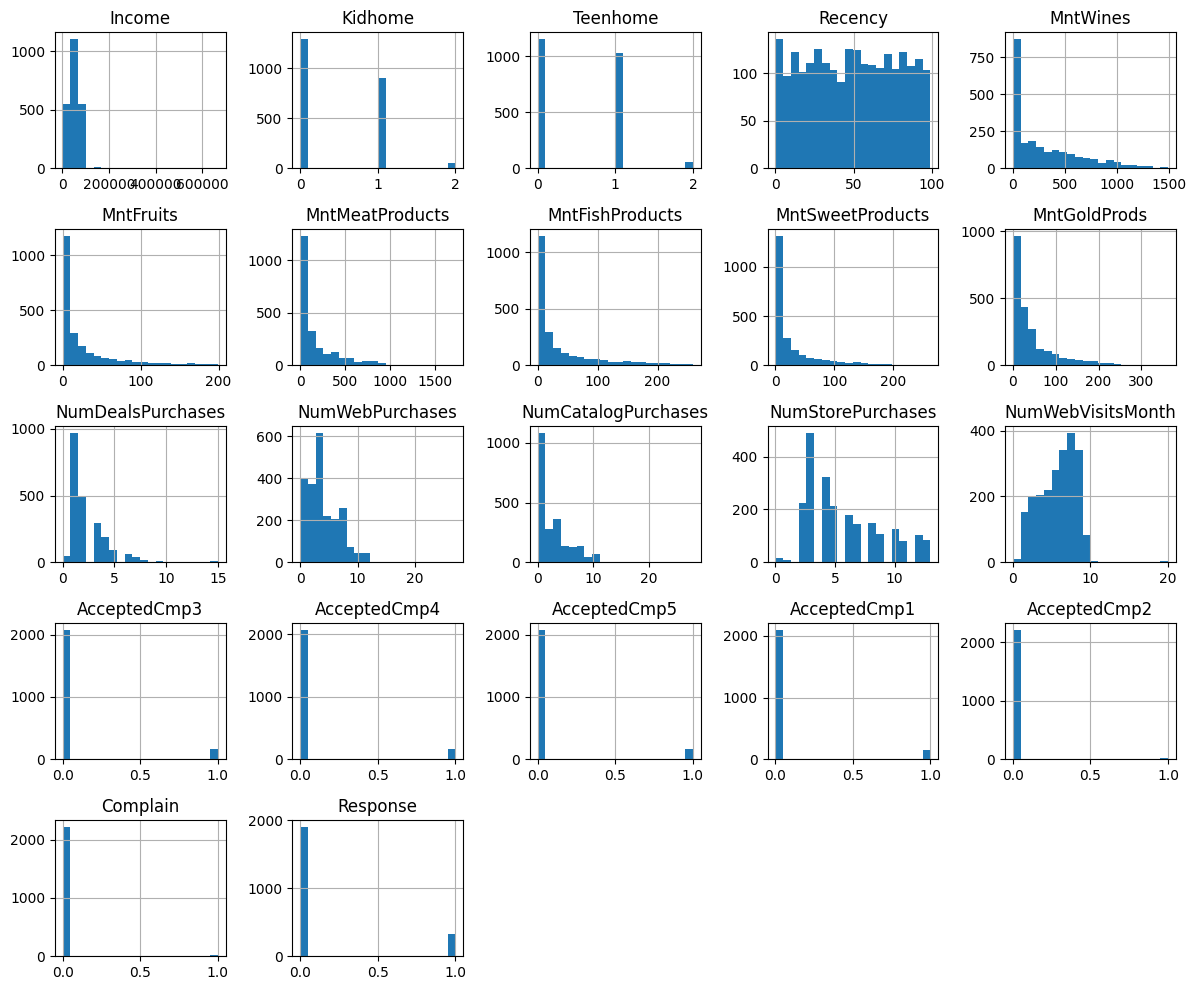

In [189]:
colonnes_numeriques = df.select_dtypes(include=['float64', 'int64']).columns

df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

# Preprocessing
Assembler les colonnes Num Purchase, à part Num Deal Purchases (achats avec une réduction), car elle peut avoir un impact différent sur ce modèle. 

Mais avant ça normalisons les données abérantes de ces colonnes, dans notre cas nous utilisons la moyenne car es valeurs sont quand même vien distribué en générale vers la gauche

Aussi normaliser les données abérantes des colonnes Mnt

In [190]:
# Récupérer les lignes contenant des valeurs aberrantes pour la colonne MonthlyIncome

def get_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    return outliers


In [191]:
purchase_colmns = [x for x in df.columns if "Purchase" in x]
purchase_colmns.remove("NumDealsPurchases")

mnt_columns = [x for x in df.columns if "Mnt" in x]
mnt_columns, purchase_colmns

(['MntWines',
  'MntFruits',
  'MntMeatProducts',
  'MntFishProducts',
  'MntSweetProducts',
  'MntGoldProds'],
 ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'])

In [192]:
accepted_columns = mnt_columns + purchase_colmns
accepted_columns

['MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases']

In [193]:
for ac in accepted_columns:
    outliers_monthly_income = get_outliers(df, ac)

    # Remplacer les valeurs aberrantes de MonthlyIncome par la médiane
    average_income = df[ac].mean()
    outliers_condition = (df[ac] < df[ac].quantile(0.25) - 1.5 * (df[ac].quantile(0.75) - df[ac].quantile(0.25))) | (df[ac] > df[ac].quantile(0.75) + 1.5 * (df[ac].quantile(0.75) - df[ac].quantile(0.25)))
    df.loc[outliers_condition, ac] = average_income

/tmp/ipykernel_25385/1014208118.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '303.9357142857143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers_condition, ac] = average_income
/tmp/ipykernel_25385/1014208118.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '26.302232142857143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers_condition, ac] = average_income
/tmp/ipykernel_25385/1014208118.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '166.95' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers_condition, ac] = average_income
/tmp/ipykernel_25385/1014208118.py:7: Fut

In [194]:
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} valeurs aberrantes")

Income: 8 valeurs aberrantes
Kidhome: 0 valeurs aberrantes
Teenhome: 0 valeurs aberrantes
Recency: 0 valeurs aberrantes
MntWines: 20 valeurs aberrantes
MntFruits: 82 valeurs aberrantes
MntMeatProducts: 167 valeurs aberrantes
MntFishProducts: 114 valeurs aberrantes
MntSweetProducts: 63 valeurs aberrantes
MntGoldProds: 110 valeurs aberrantes
NumDealsPurchases: 86 valeurs aberrantes
NumWebPurchases: 0 valeurs aberrantes
NumCatalogPurchases: 0 valeurs aberrantes
NumStorePurchases: 0 valeurs aberrantes
NumWebVisitsMonth: 8 valeurs aberrantes
AcceptedCmp3: 163 valeurs aberrantes
AcceptedCmp4: 167 valeurs aberrantes
AcceptedCmp5: 163 valeurs aberrantes
AcceptedCmp1: 144 valeurs aberrantes
AcceptedCmp2: 30 valeurs aberrantes
Complain: 21 valeurs aberrantes
Response: 334 valeurs aberrantes


Fusion des colonnes Purchases

In [195]:
df["NumPurchases"] = df[purchase_colmns].sum(axis=1)
df = df.drop(columns=purchase_colmns)

# Pipeline

In [196]:
target = "Response"

y = df[target].astype(int)
X = df.drop(columns=[target])

In [197]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   
)

print("Train y distribution:\n", y_train.value_counts(normalize=True))
print("Valid y distribution:\n", y_test.value_counts(normalize=True))

Train y distribution:
 Response
0    0.851004
1    0.148996
Name: proportion, dtype: float64
Valid y distribution:
 Response
0    0.850446
1    0.149554
Name: proportion, dtype: float64


In [198]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = ["Education", "Marital_Status"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [199]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features),
        ("cat_non_ord", categorical_pipeline, cat_features),
    ],
    remainder="drop"
)

In [200]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000, random_state=42)

pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

In [201]:
pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat_non_ord', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transform

In [202]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [203]:
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8906
F1-score:  0.4948

Confusion matrix:
 [[375   6]
 [ 43  24]]

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       381
           1       0.80      0.36      0.49        67

    accuracy                           0.89       448
   macro avg       0.85      0.67      0.72       448
weighted avg       0.88      0.89      0.87       448



In [204]:
import pickle

# Sauvegarde du pipeline complet (prétraitement + modèle)
with open("ecommerce_model.pkl", "wb") as f:
    pickle.dump(pipe, f)

print("Modèle sauvegardé dans ecommerce_model.pkl")

Modèle sauvegardé dans ecommerce_model.pkl


In [205]:
with open("ecommerce_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)


In [206]:
outliers_monthly_income

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response


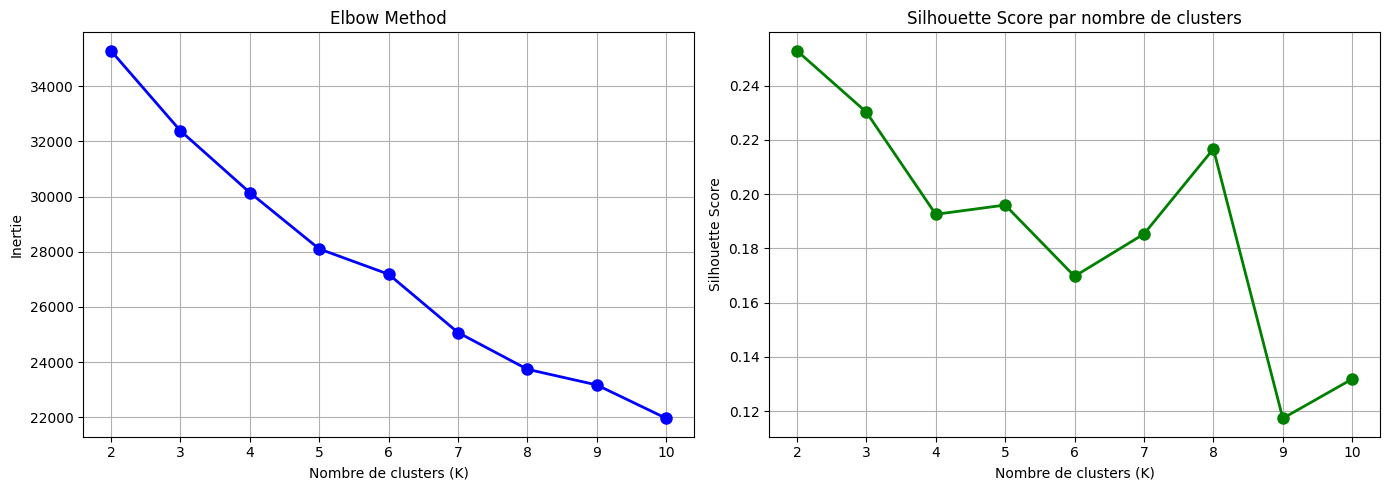

In [207]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Utiliser les données transformées par le preprocessor
X_transformed = preprocessor.fit_transform(X)

# Déterminer le nombre optimal de clusters (Elbow Method)
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_transformed)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_transformed, kmeans.labels_))

# Afficher les courbes
plt.figure(figsize=(14, 5))

# Graphique 1 : Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertie")
plt.title("Elbow Method")
plt.grid()

# Graphique 2 : Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score par nombre de clusters")
plt.grid()

plt.tight_layout()
plt.show()

# Utiliser le meilleur K (par exemple K=3)



✅ Clustering avec K=2
Distribution des clusters :
0     941
1    1299
Name: count, dtype: int64

Silhouette Score: 0.2528
Davies-Bouldin Score: 1.7015


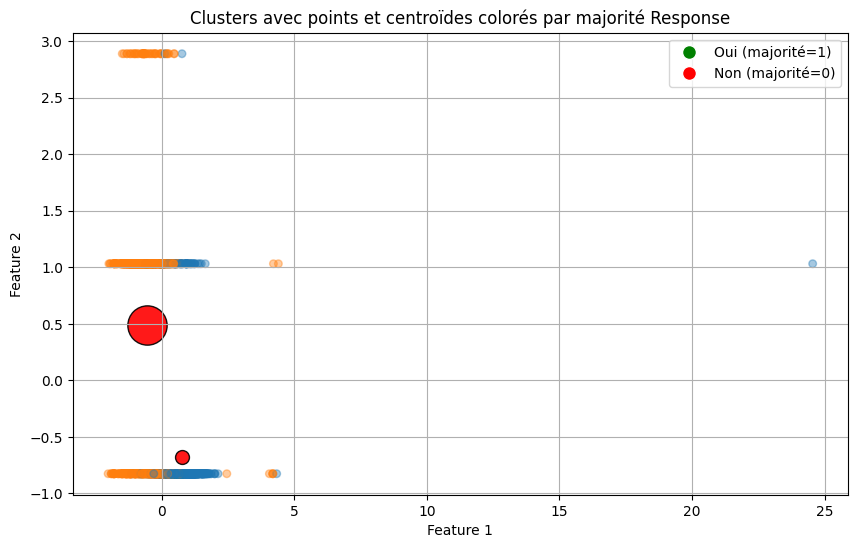

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

best_k = 2
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_transformed)

# Ajouter les clusters au dataframe original
df['Cluster'] = clusters

print(f"\n✅ Clustering avec K={best_k}")
print(f"Distribution des clusters :\n{pd.Series(clusters).value_counts().sort_index()}")
print(f"\nSilhouette Score: {silhouette_score(X_transformed, clusters):.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_transformed, clusters):.4f}")


# Appliquer KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X_transformed)
centers = kmeans.cluster_centers_

# Calculer taille et majorité par cluster
cluster_info = df.groupby('Cluster')['Response'].agg(['size', 'mean']).reindex(range(n_clusters)).fillna(0)

# Couleur des points selon la majorité du cluster
point_colors = ['green' if cluster_info.loc[cluster_id, 'mean'] >= 0.5 else 'red' for cluster_id in y_pred]

plt.figure(figsize=(10, 6))
# Tracer les points
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=clusters, cmap=cmap, norm=norm, alpha=0.4, s=30)

# Taille des centroïdes proportionnelle à la taille du cluster
min_s, max_s = 100, 800
sizes = cluster_info['size']
if sizes.max() != sizes.min():
    scaled = min_s + (sizes - sizes.min()) / (sizes.max() - sizes.min()) * (max_s - min_s)
else:
    scaled = np.full_like(sizes, (min_s + max_s) / 2)

# Tracer les centroïdes
for i, center in enumerate(centers):
    majority = cluster_info.loc[i, 'mean']
    size_i = int(scaled.loc[i])
    color = 'green' if majority >= 0.5 else 'red'
    plt.scatter(center[0], center[1], c=color, s=size_i, edgecolors='black', linewidth=1, alpha=0.9)

plt.title("Clusters avec points et centroïdes colorés par majorité Response")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Légende
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Oui (majorité=1)', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Non (majorité=0)', markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements)
plt.grid()
plt.show()

In [209]:
import pandas as pd

# Supposons que ton DataFrame s'appelle df
# Créer le dictionnaire du nouveau client
new_client = {
    "Education": "Master",
    "Marital_Status": "Single",
    "Income": 9000.0,
    "Kidhome": 0,
    "Teenhome": 1,
    "Recency": 10,
    "MntWines": 100,
    "MntFruits": 20,
    "MntMeatProducts": 1,
    "MntFishProducts": 10,
    "MntSweetProducts": 1,
    "MntGoldProds": 0,
    "NumDealsPurchases": 0,
    "NumPurchases": 500,
    "NumWebVisitsMonth": 0,
    "AcceptedCmp3": 0,
    "AcceptedCmp4": 0,
    "AcceptedCmp5": 1,
    "AcceptedCmp1": 1,
    "AcceptedCmp2": 0,
    "Complain": 0,
    "Response": 0
}

# Ajouter le nouveau client
prediction = loaded_model.predict(pd.DataFrame([new_client]))[0]
proba = loaded_model.predict_proba(pd.DataFrame([new_client]))[0][1]

print(prediction, "Réponse prédite")
print(proba, "Probabilité associée")

0 Réponse prédite
0.03196573195496789 Probabilité associée
